# Download_and_Prepare_Equity_Indices_for_Market_Risk

## 📘 Introduction

In this notebook, we prepare the framework for downloading and processing data for a broad set of major global equity indices using `yfinance`. 
Where necessary, we adjust their prices to USD using the corresponding foreign exchange rates.

Instead of combining all indices into a single DataFrame, we structure the data into a clean dictionary (`Equity_ind`) where each index has its own separate DataFrame of adjusted USD prices.

The dataset will cover two key periods:
- **Pre-COVID period**: approximately two years before the pandemic,
- **Period including the COVID outbreak**: starting from early 2020.

We cover a globally diversified set of equity markets, including:
- The **S&P 500** (United States),
- The **Dow Jones Industrial Average** (United States),
- The **NASDAQ Composite** (United States),
- The **FTSE 100** (United Kingdom),
- The **DAX Index** (Germany/European Union),
- The **CAC 40** (France),
- The **Swiss Market Index** (Switzerland),
- The **IBEX 35** (Spain),
- The **EURO STOXX 50** (Eurozone),
- The **Nikkei 225** (Japan),
- The **Hang Seng Index** (Hong Kong/China),
- The **Hang Seng China Enterprises Index** (Hong Kong/China),
- The **Shanghai Composite Index** (China),
- And the **S&P BSE SENSEX** (India).

Each of these indices provides broad exposure to its respective regional market, offering a foundation for diversified portfolio analysis and risk assessment across major world economies.


## 2. Import Required Libraries

In [41]:
import yfinance as yf
import pandas as pd
import json
import matplotlib.pyplot as plt

## 3. Time Periods for Market Risk Analysis

We work with two-year periods of trading data, starting either before the COVID-19 pandemic or covering its initial phase, depending on the selected dates.

- **Before COVID-19 market impact:**  
  - `start_date = "2018-02-07"`  
  - `end_date = "2020-02-04"`

- **Including the COVID-19 outbreak period:**  
  - `start_date = "2018-08-27"`  
  - `end_date = "2020-08-21"`

The first time window is deliberately selected to capture a relatively stable period before markets fully absorbed the volatility, risk, and uncertainty caused by the COVID-19 pandemic.  
We use approximately two years of trading data, which corresponds to roughly **500 trading days**, providing enough observations to build a statistically meaningful dataset.  
Our dataset therefore consists of approximately **500 trading days** for each selected equity index.


In [42]:
start_pre_covid = "2018-02-07"
end_pre_covid = "2020-02-04"

start_with_covid = "2018-08-27"
end_with_covid = "2020-08-21"

# Output

At the end of this notebook, we will produce:

- `Equity_ind`: a single dictionary containing major equity indices, all converted to USD, 
  with two sub-periods stored separately:
  - `index_usd_values_pre_covid`: representing the **pre-COVID** period,
  - `index_usd_values_with_covid`: representing the **period including the COVID-19 outbreak**.

Each index will have approximately 500 trading days of data for each period, cleaned, aligned, and ready for further analysis.
The final dataset will enable direct comparison of different equity markets across major economies under a consistent (USD-based) valuation baseline.


In [43]:
# Define the major equity indices to download, along with FX conversion info (via fx_symbol) 
# and placeholders for USD-adjusted index values (pre-COVID and with-COVID periods).

Equity_ind_template = {
    # USA
    "^GSPC": {
        "name": "S&P 500",
        "fx_symbol": None,
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^DJI": {
        "name": "Dow Jones Industrial Average",
        "fx_symbol": None,
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^IXIC": {
        "name": "NASDAQ Composite",
        "fx_symbol": None,
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },

    # Europe
    "^FTSE": {
        "name": "FTSE 100",
        "fx_symbol": "GBPUSD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^GDAXI": {
        "name": "DAX",
        "fx_symbol": "EURUSD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^FCHI": {
        "name": "CAC 40",
        "fx_symbol": "EURUSD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^SSMI": {
        "name": "Swiss Market Index (SMI)",
        "fx_symbol": "CHFUSD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^IBEX": {
        "name": "IBEX 35",
        "fx_symbol": "EURUSD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^STOXX50E": {
        "name": "EURO STOXX 50",
        "fx_symbol": "EURUSD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },

    # Asia
    "^N225": {
        "name": "Nikkei 225",
        "fx_symbol": "JPY=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^HSI": {
        "name": "Hang Seng Index",
        "fx_symbol": "HKD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "000001.SS": {
        "name": "Shanghai Composite Index",
        "fx_symbol": "CNY=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },
    "^HSCE": {
        "name": "Hang Seng China Enterprises Index",
        "fx_symbol": "HKD=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    },

    # India
    "^BSESN": {
        "name": "S&P BSE SENSEX",
        "fx_symbol": "INR=X",
        "index_usd_values_pre_covid": None,
        "index_usd_values_with_covid": None
    }
}


# Save Equity_ind as JSON
with open('Equity_ind_template.json', 'w') as f:
    json.dump(Equity_ind_template, f, indent=4)

# Loading the Template and Preparing for Data Download

Now that we have created and saved the `Equity_ind` template as a JSON file, 
we can begin working with it.

In this next step, we will load the JSON template back into our notebook 
and define a reusable function to download the index data, adjust it to USD where necessary, 
and populate the corresponding fields (`index_usd_values_pre_covid` and `index_usd_values_with_covid`) in the dictionary.

This will allow us to automate the downloading and preparation of equity index data 
for different periods without rewriting code each time.


In [44]:
with open('Equity_ind_template.json', 'r') as f:
    Equity_ind = json.load(f)

In [45]:
Equity_ind

{'^GSPC': {'name': 'S&P 500',
  'fx_symbol': None,
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^DJI': {'name': 'Dow Jones Industrial Average',
  'fx_symbol': None,
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^IXIC': {'name': 'NASDAQ Composite',
  'fx_symbol': None,
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^FTSE': {'name': 'FTSE 100',
  'fx_symbol': 'GBPUSD=X',
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^GDAXI': {'name': 'DAX',
  'fx_symbol': 'EURUSD=X',
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^FCHI': {'name': 'CAC 40',
  'fx_symbol': 'EURUSD=X',
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^SSMI': {'name': 'Swiss Market Index (SMI)',
  'fx_symbol': 'CHFUSD=X',
  'index_usd_values_pre_covid': None,
  'index_usd_values_with_covid': None},
 '^IBEX': {'name': 'IBEX 35',


## Defining the Download and Fill Function

We now define a reusable function, `download_and_fill_equity_data`, that automates the downloading of index data, adjusts for currency conversion when necessary, and fills the corresponding fields in the `Equity_ind` dictionary.

This function allows us to prepare datasets for different periods without rewriting download logic each time.


In [46]:
# Define a function to download index data and fill the Equity_ind dictionary



def download_and_fill_equity_data(Equity_ind, start_date, end_date, period_field, progress=True):
    """
    Download equity index data (and FX rates if needed), convert to USD if necessary,
    and fill the Equity_ind dictionary under the specified period_field.

    Parameters
    ----------
    Equity_ind : dict
        Dictionary containing equity indices and FX info.
    start_date : str
        Start date for data download (format: 'YYYY-MM-DD').
    end_date : str
        End date for data download (format: 'YYYY-MM-DD').
    period_field : str
        Field name to store the downloaded USD-adjusted DataFrame 
        (e.g., 'index_usd_values_pre_covid' or 'index_usd_values_with_covid').
    progress : bool, optional
        Show download progress bar (default is False).

    Returns
    -------
    dict
        Updated Equity_ind dictionary with downloaded data.
    """

    for tic in Equity_ind:
        fx_sym = Equity_ind[tic]["fx_symbol"]
        
        if fx_sym is None:
            # No FX conversion needed
            data = yf.download(
                tickers=[tic],
                start=start_date,
                end=end_date,
                progress=progress
            )["Close"]
            data.dropna(inplace=True)
            Equity_ind[tic][period_field] = data
        
        else:
            # Need FX conversion
            data = yf.download(
                tickers=[tic, fx_sym],
                start=start_date,
                end=end_date,
                progress=progress
            )["Close"]
            data.dropna(inplace=True)
            Equity_ind[tic][period_field] = (data[tic] / data[fx_sym]).to_frame(name=tic)

         

    return Equity_ind


## Downloading and Filling the Data for Each Period

We now perform three main steps to populate the `Equity_ind` dictionary with actual USD-adjusted index data:

1. **Load the Template**:  
   Load the saved `Equity_ind_template.json` into the notebook to initialize the dictionary structure.

2. **Fill the Pre-COVID Period**:  
   Define the pre-COVID time window (`2018-02-07` to `2020-02-04`) and download the corresponding index data.

3. **Fill the with-COVID Period**:  
   Define the COVID-outbreak time window (`2018-08-27` to `2020-08-21`) and download the corresponding index data.

After these steps, each index entry will have two USD-adjusted time series, ready for further analysis.


In [52]:
start_pre_covid = "2018-02-07"
end_pre_covid = "2020-02-04"

start_with_covid = "2018-08-27"
end_with_covid = "2020-08-21"

In [53]:
with open('Equity_ind_template.json', 'r') as f:
    Equity_ind = json.load(f)

In [54]:
# Example: Fill the pre-COVID data
Equity_ind = download_and_fill_equity_data(Equity_ind, start_pre_covid, end_pre_covid, "index_usd_values_pre_covid")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [56]:
# Example: Fill the with-COVID data
Equity_ind = download_and_fill_equity_data(Equity_ind, start_with_covid, end_with_covid, "index_usd_values_with_covid")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


## Inspecting a Specific Ticker's Data

We can quickly check the first few rows of the USD-adjusted index values for a selected ticker.


In [59]:
# Example: Visual inspection for one specific ticker

ticker = "^HSI"  # Change this to any ticker you want

print(f"--- {Equity_ind[ticker]['name']} ({ticker}) ---\n")

# Pre-COVID DataFrame
if Equity_ind[ticker]["index_usd_values_pre_covid"] is not None:
    print("Pre-COVID Period:")
    display(Equity_ind[ticker]["index_usd_values_pre_covid"].head())
else:
    print("Pre-COVID data: None")

print("\n")

# With-COVID DataFrame
if Equity_ind[ticker]["index_usd_values_with_covid"] is not None:
    print("With-COVID Period:")
    display(Equity_ind[ticker]["index_usd_values_with_covid"].head())
else:
    print("With-COVID data: None")


--- Hang Seng Index (^HSI) ---

Pre-COVID Period:


,^HSI
Date,
2018-02-07,3878.485255
2018-02-08,3895.020485
2018-02-09,3773.423911
2018-02-12,3768.281156
2018-02-13,3816.089461




With-COVID Period:


,^HSI
Date,
2018-08-27,3601.573261
2018-08-28,3611.873776
2018-08-29,3619.744161
2018-08-30,3588.554318
2018-08-31,3553.088938


## Visualizing Equity Indices: Pre-COVID vs. With-COVID Periods

In this section, we visualize the USD-adjusted index values for each major equity index, 
comparing the behavior during the pre-COVID period and the period overlapping the COVID-19 outbreak.

For each index, we plot both periods together using distinct colors, allowing for a clear visual comparison of market behavior before and during the pandemic.


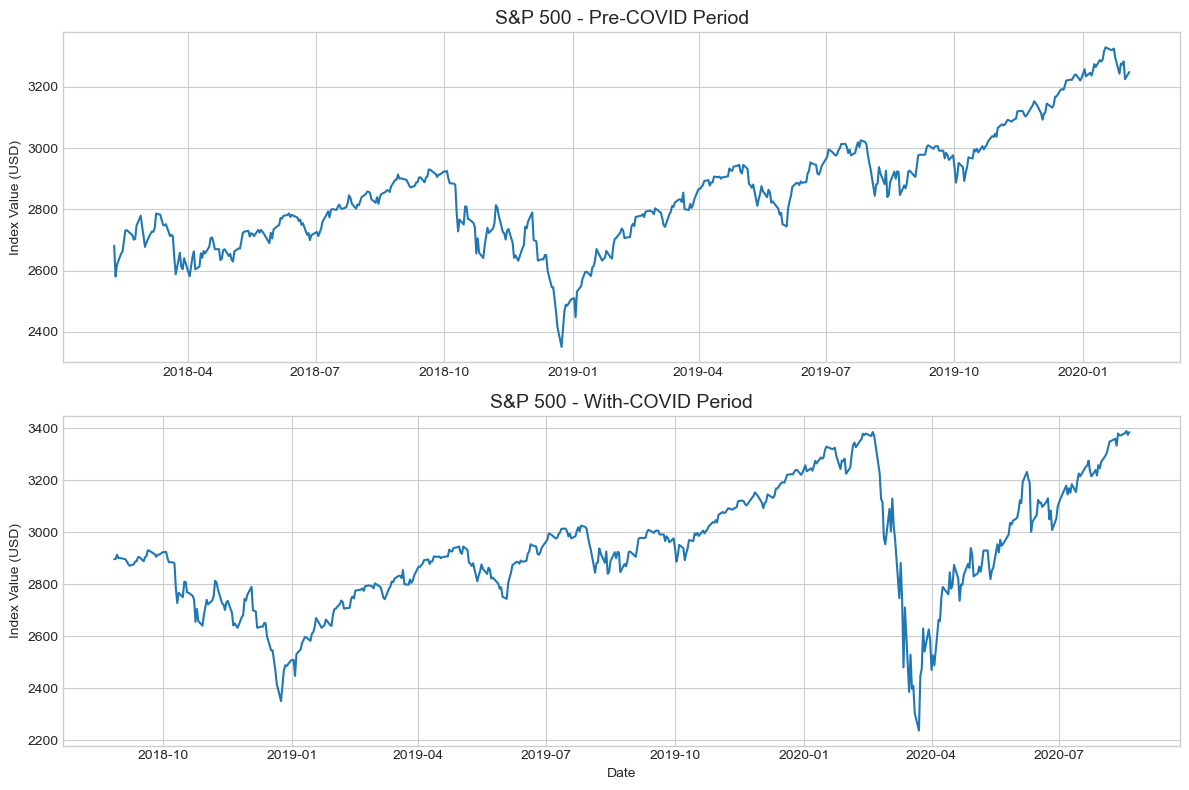

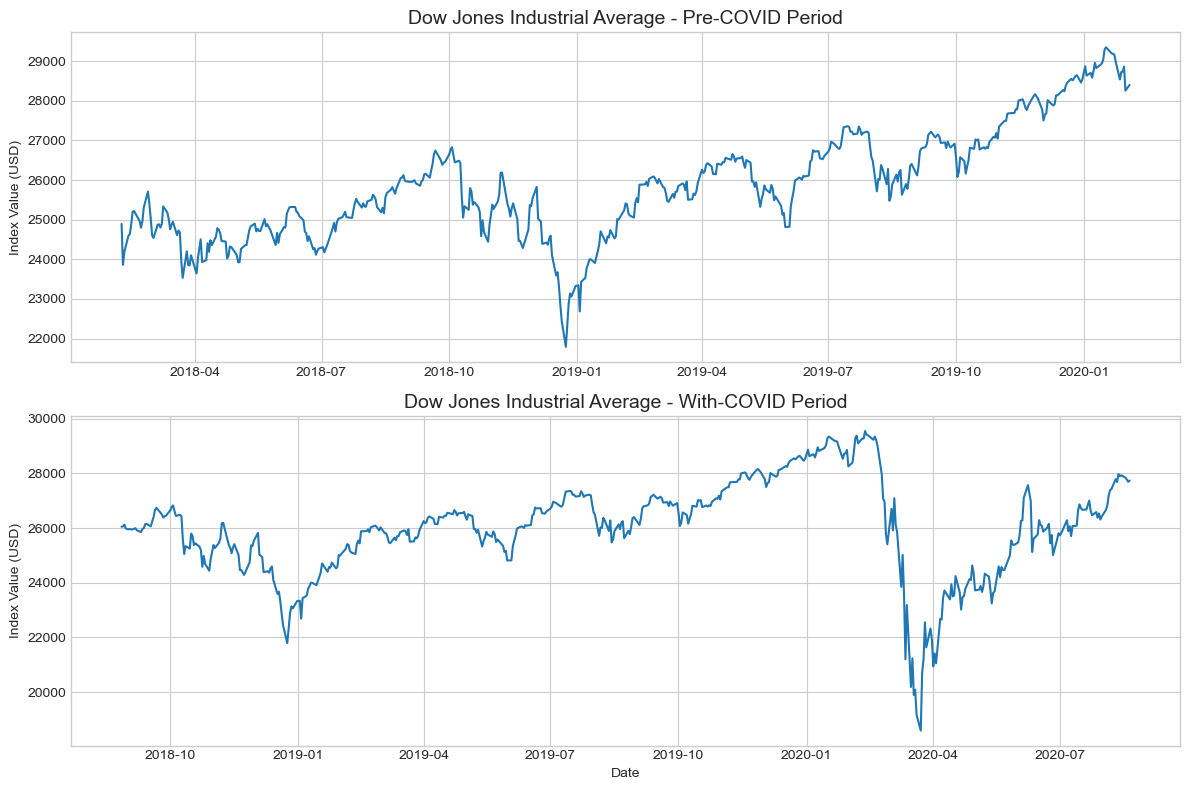

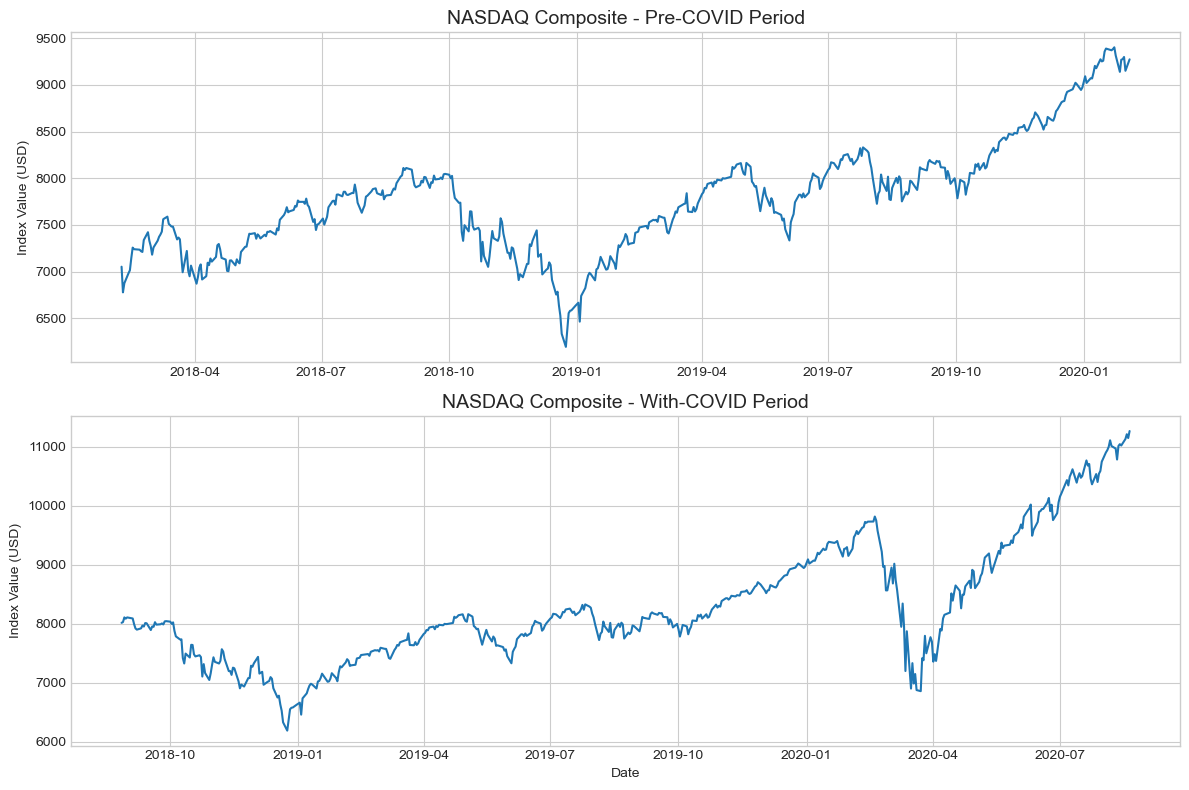

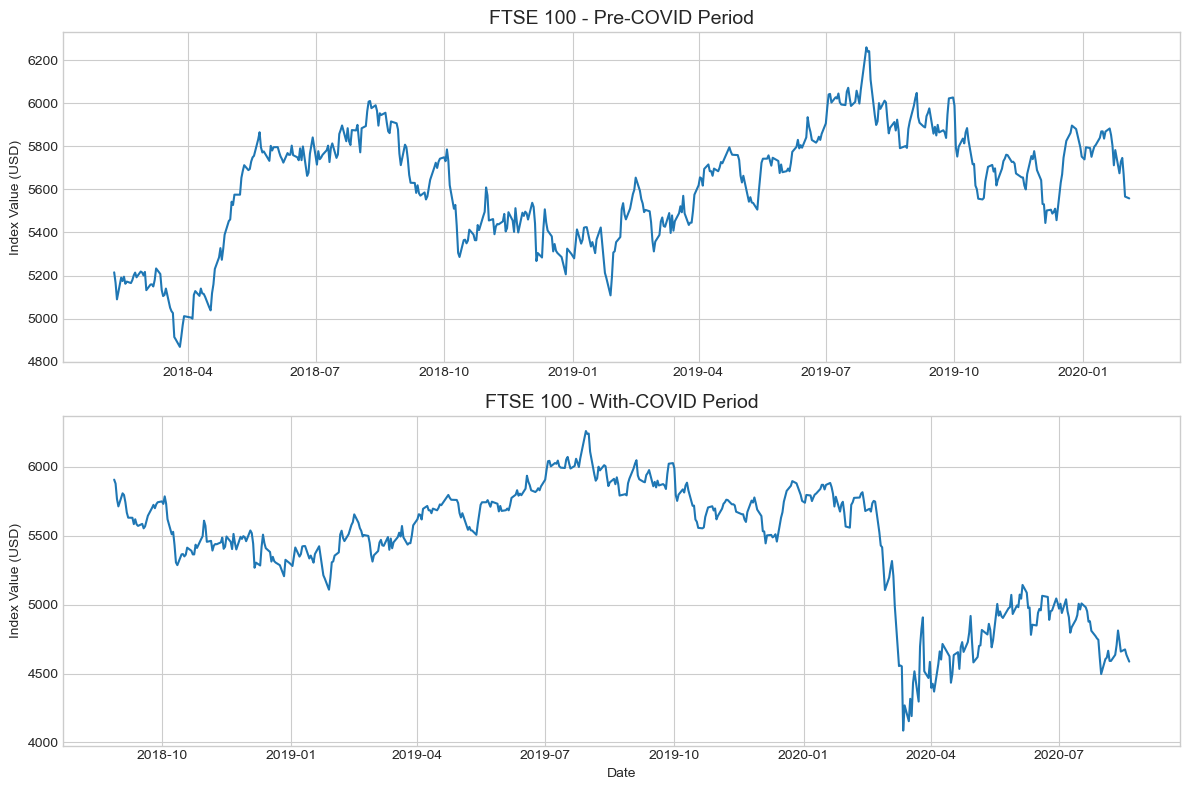

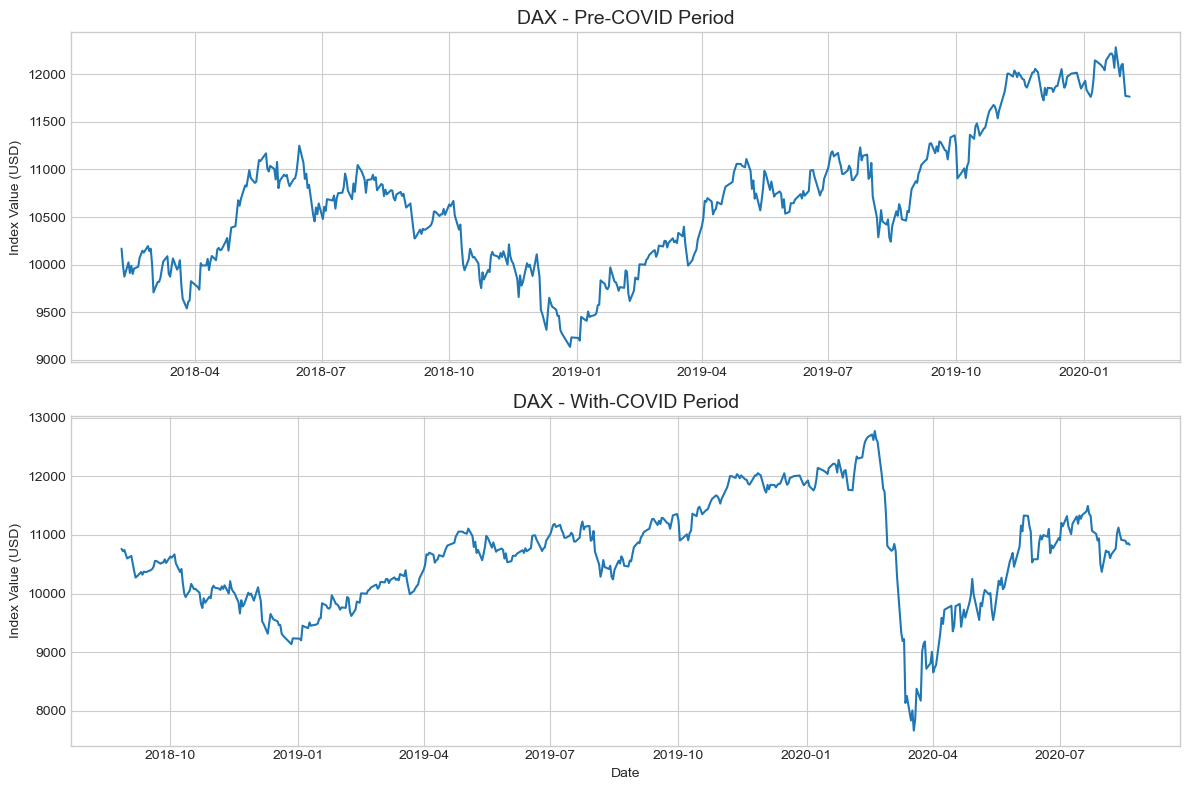

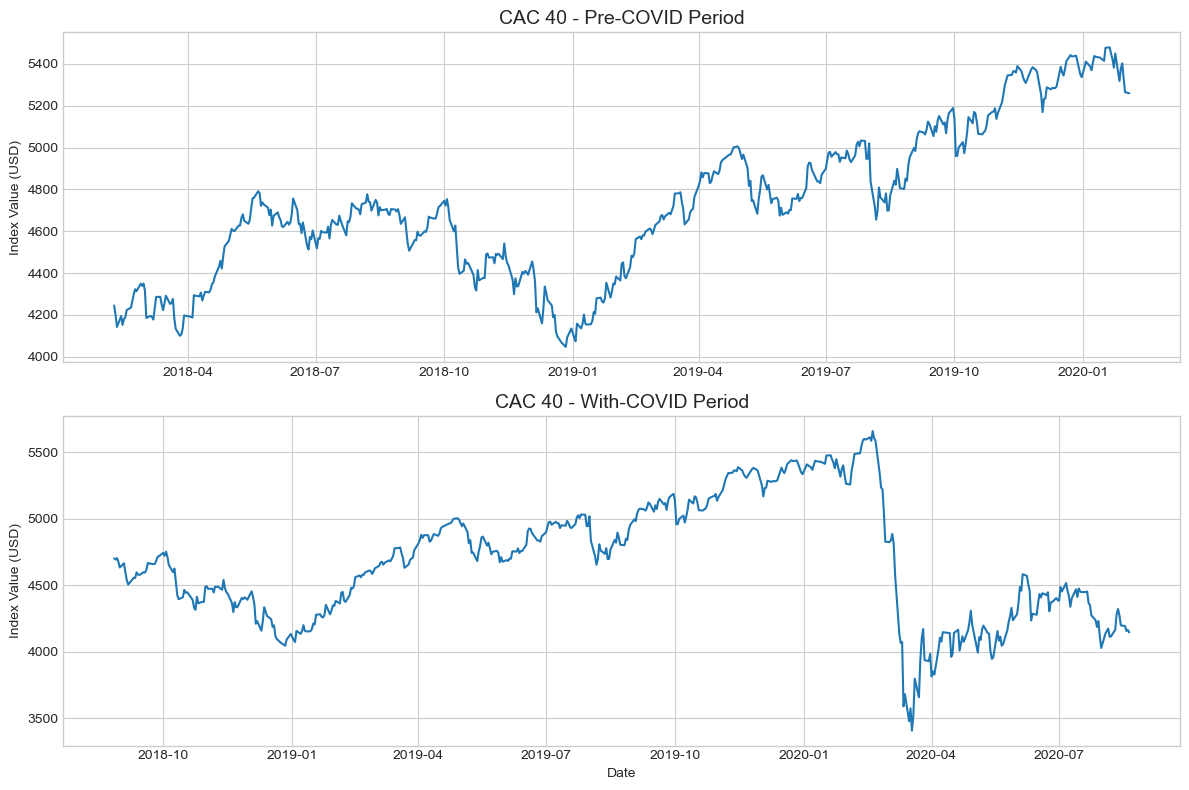

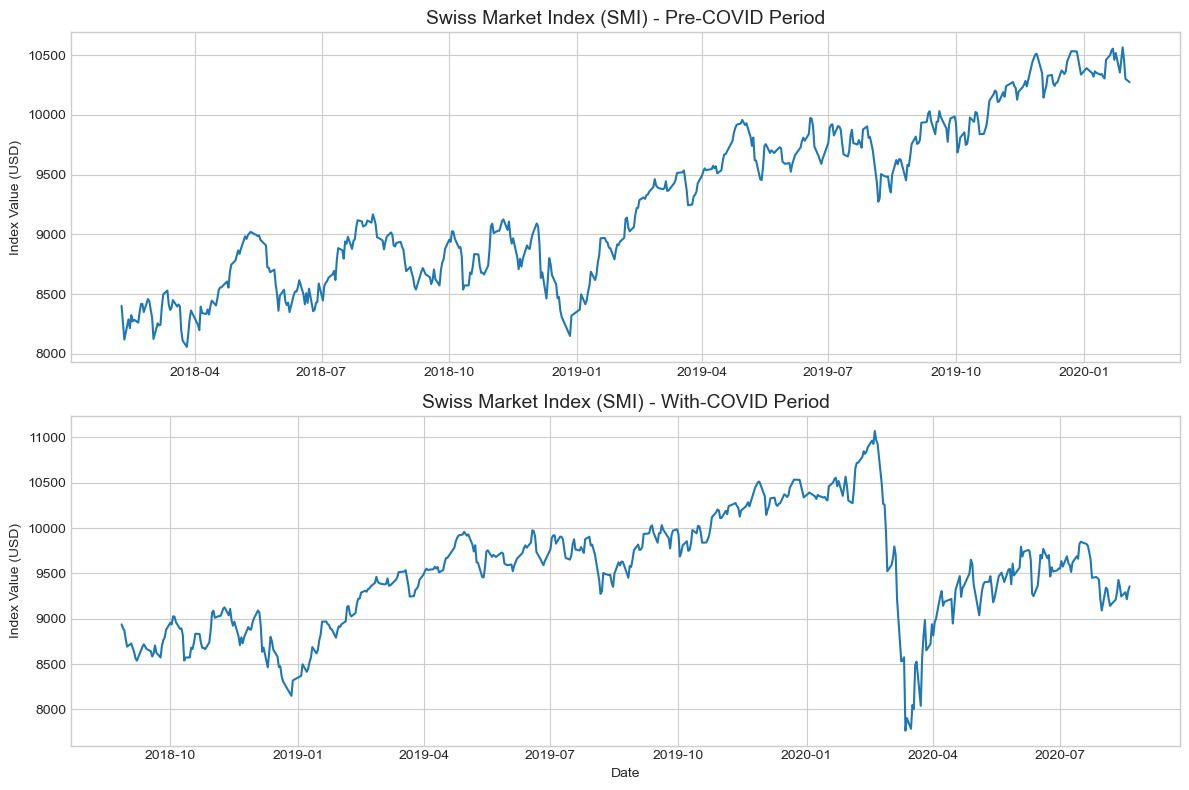

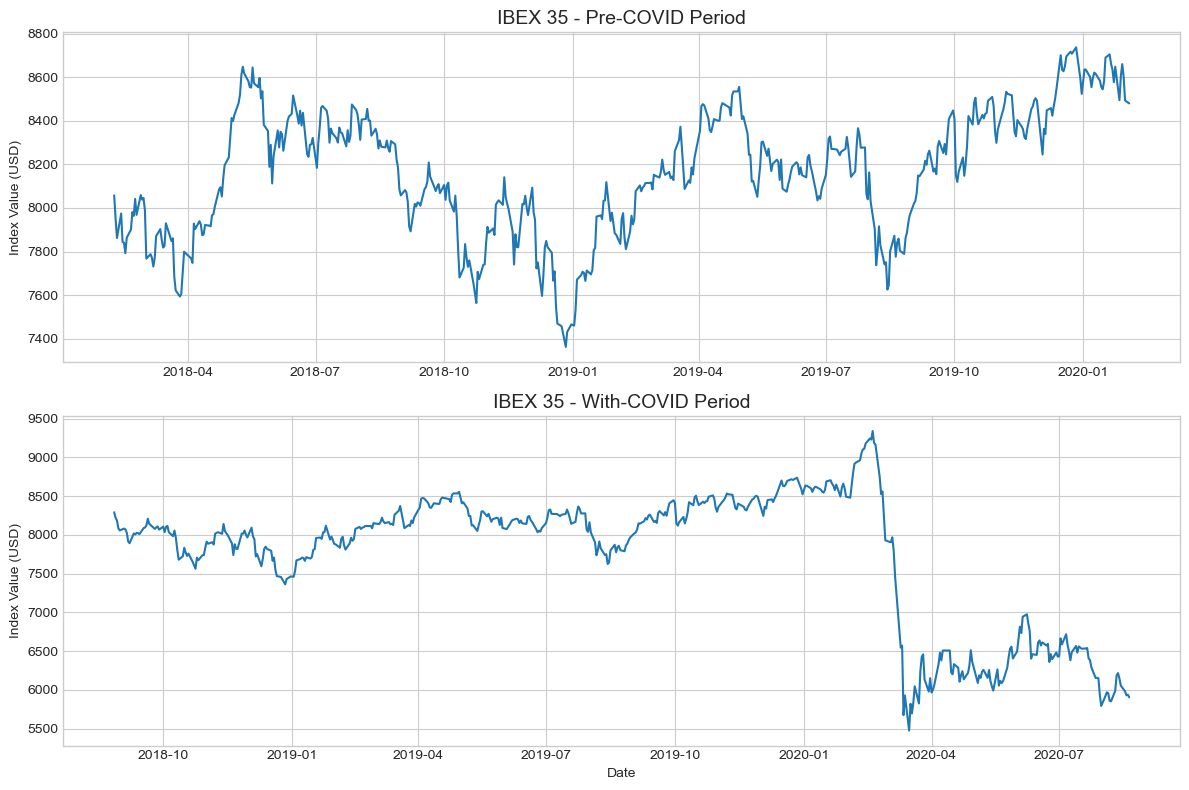

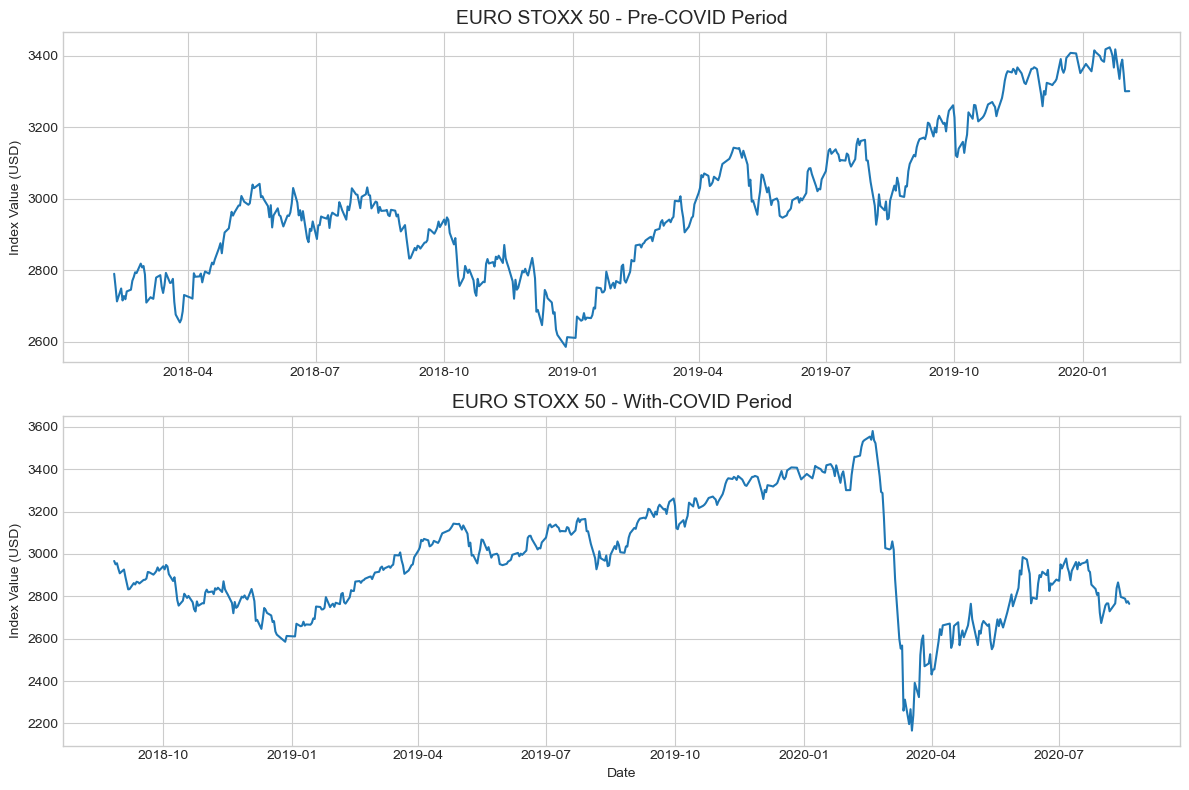

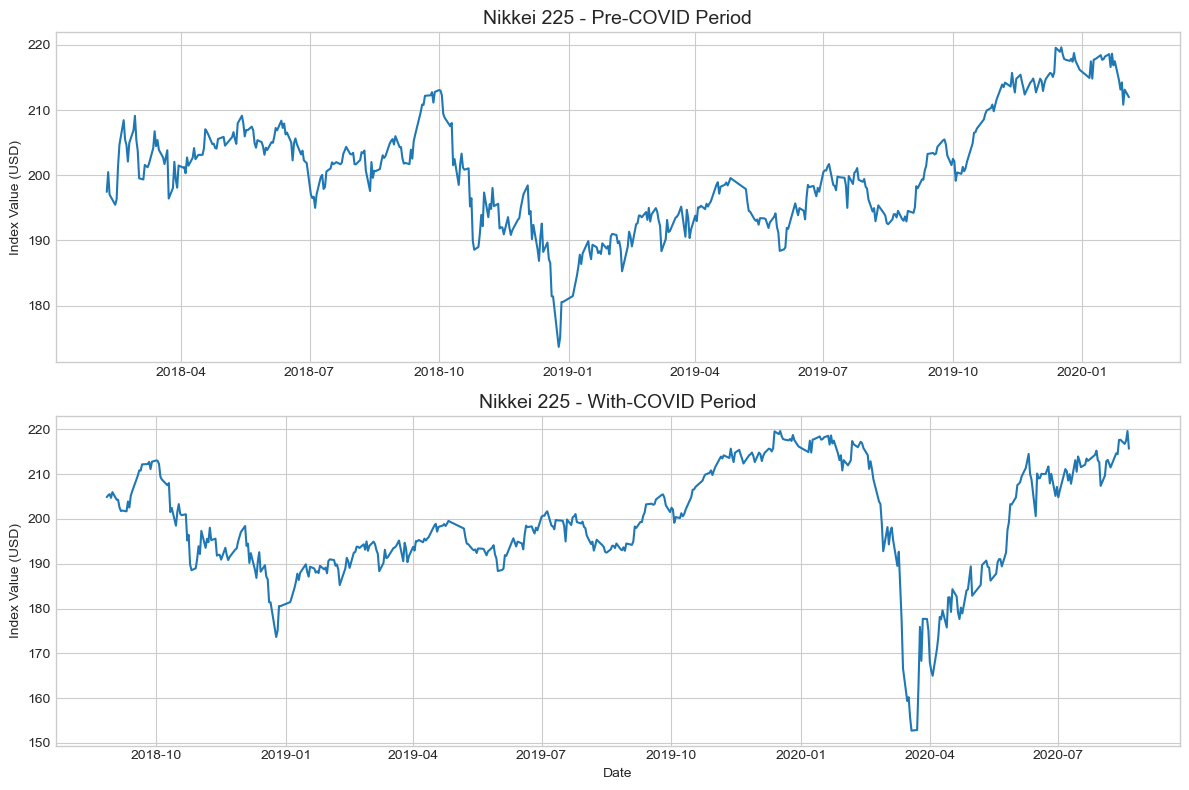

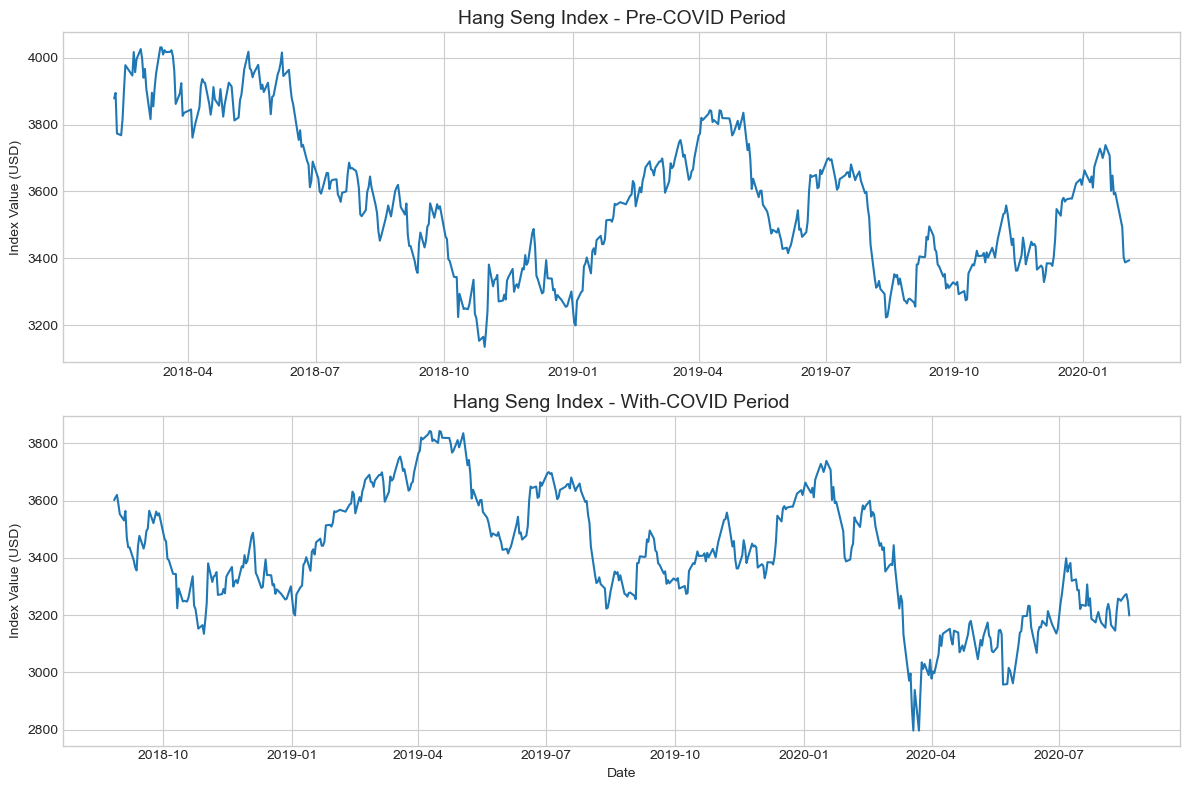

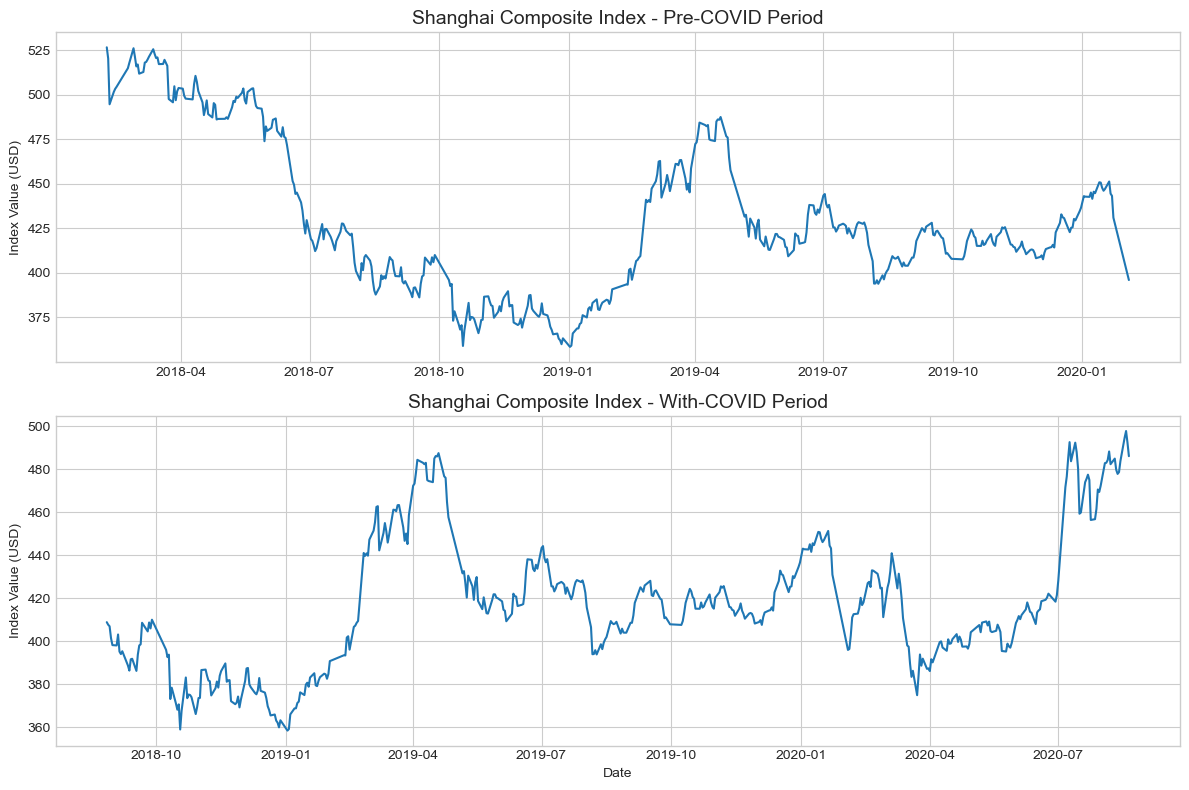

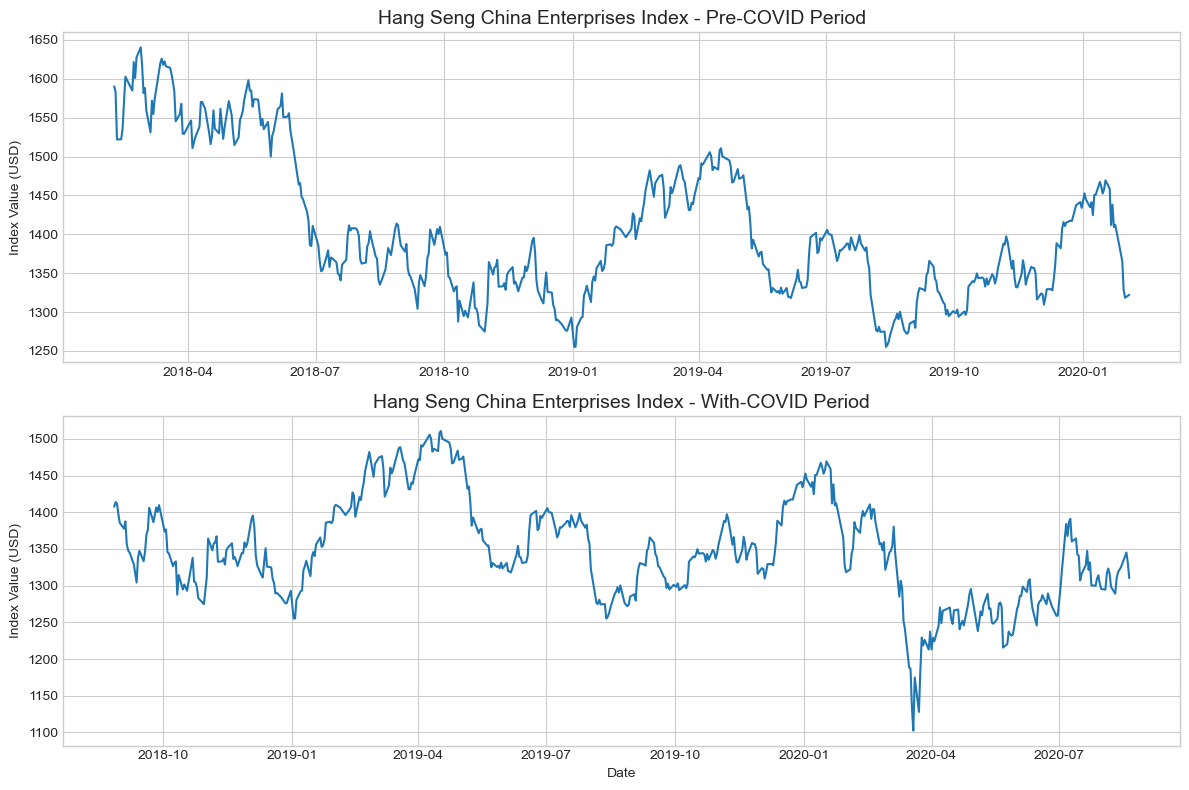

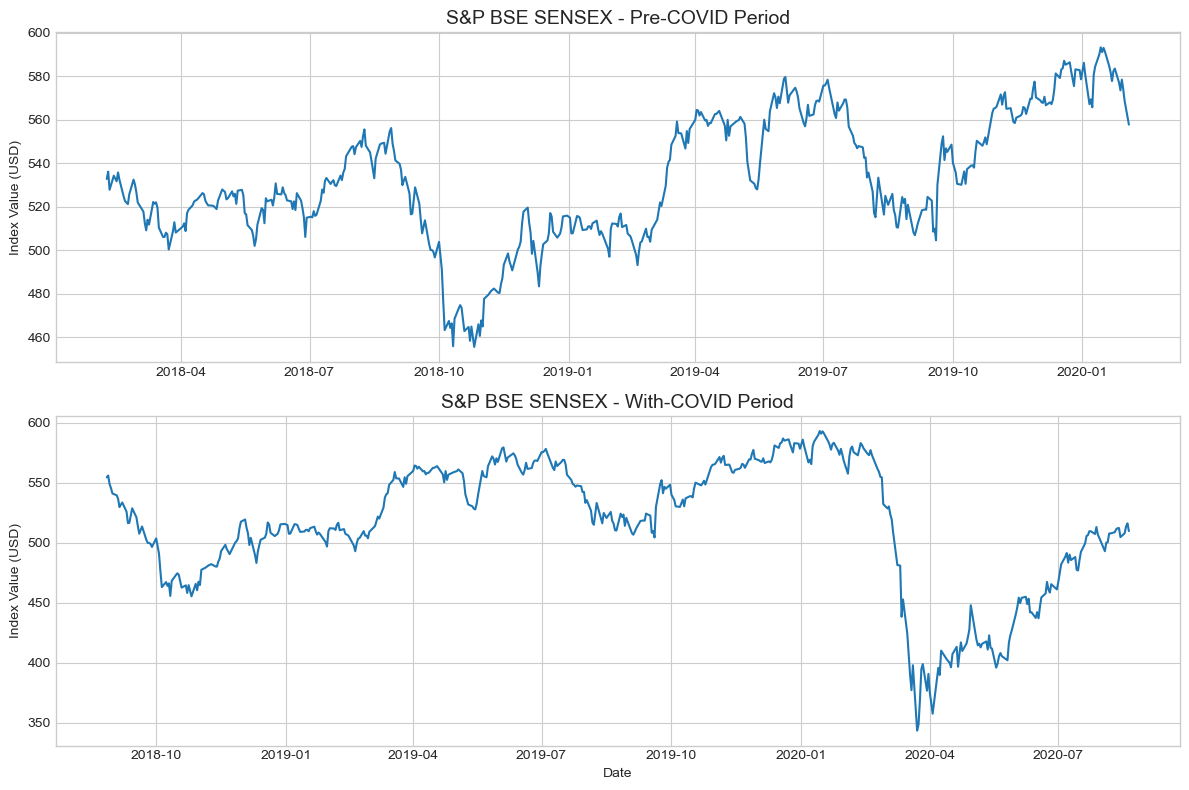

In [39]:
# Set general plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Loop over all indices
for ticker, info in Equity_ind.items():
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    # Plot pre-COVID
    if info["index_usd_values_pre_covid"] is not None:
        axs[0].plot(info["index_usd_values_pre_covid"].index, info["index_usd_values_pre_covid"].iloc[:,0])
        axs[0].set_title(f"{info['name']} - Pre-COVID Period", fontsize=14)
        axs[0].set_ylabel('Index Value (USD)')
    
    # Plot with-COVID
    if info["index_usd_values_with_covid"] is not None:
        axs[1].plot(info["index_usd_values_with_covid"].index, info["index_usd_values_with_covid"].iloc[:,0])
        axs[1].set_title(f"{info['name']} - With-COVID Period", fontsize=14)
        axs[1].set_ylabel('Index Value (USD)')
        axs[1].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()


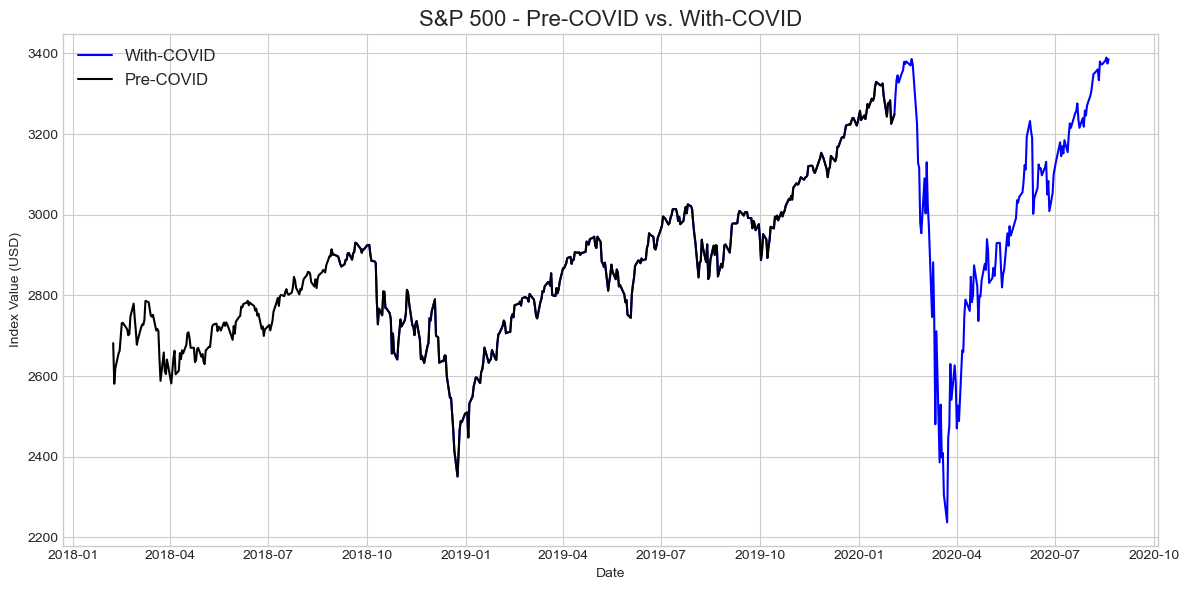

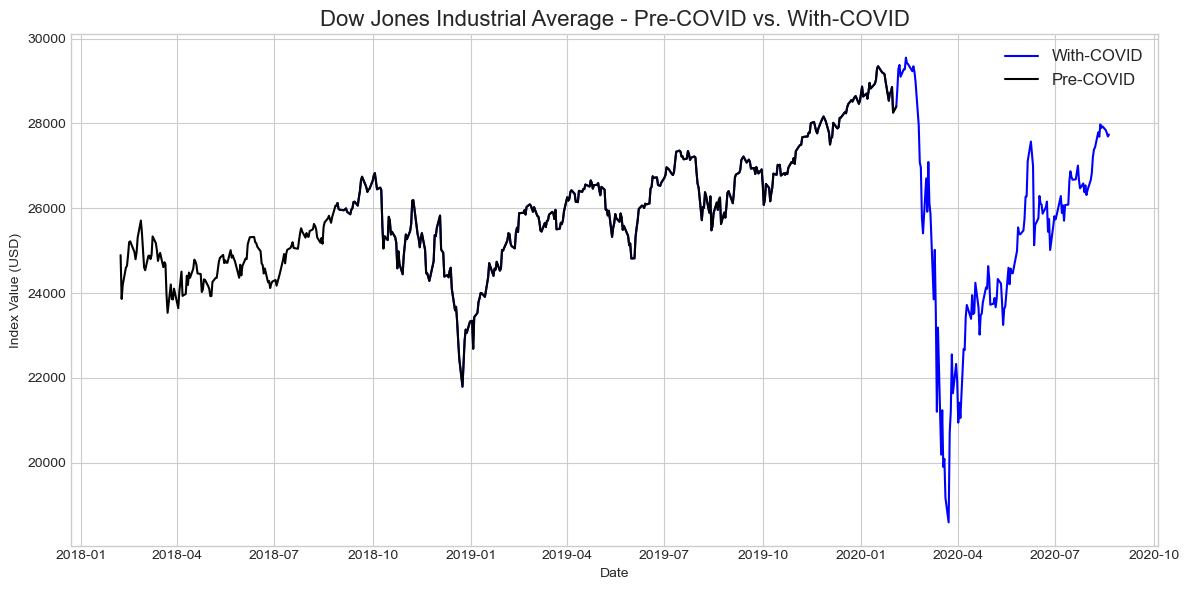

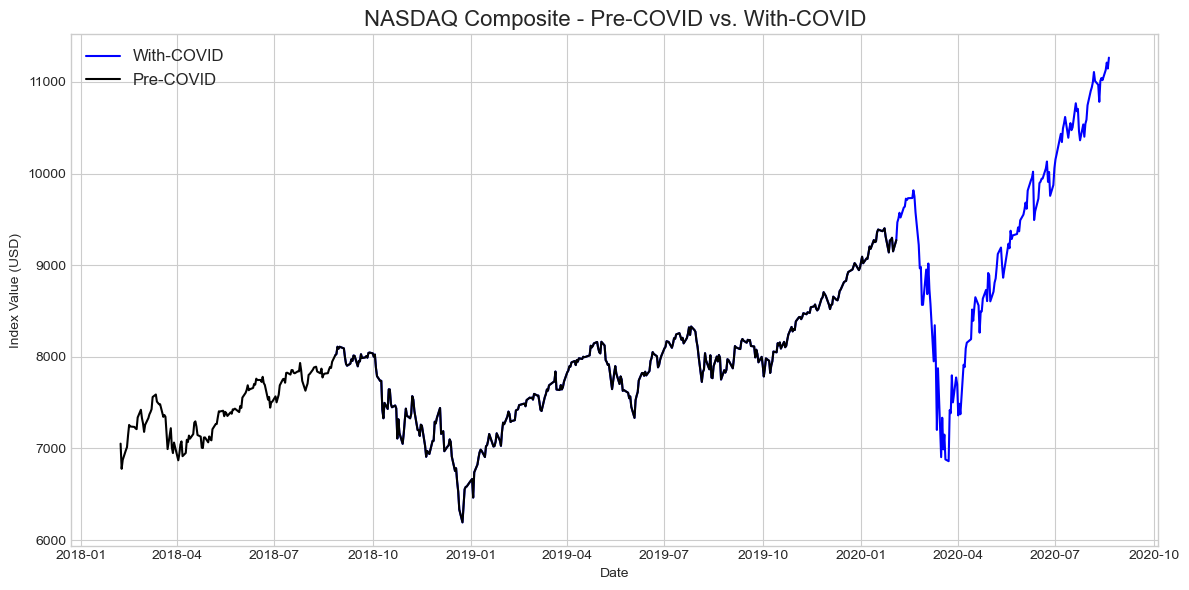

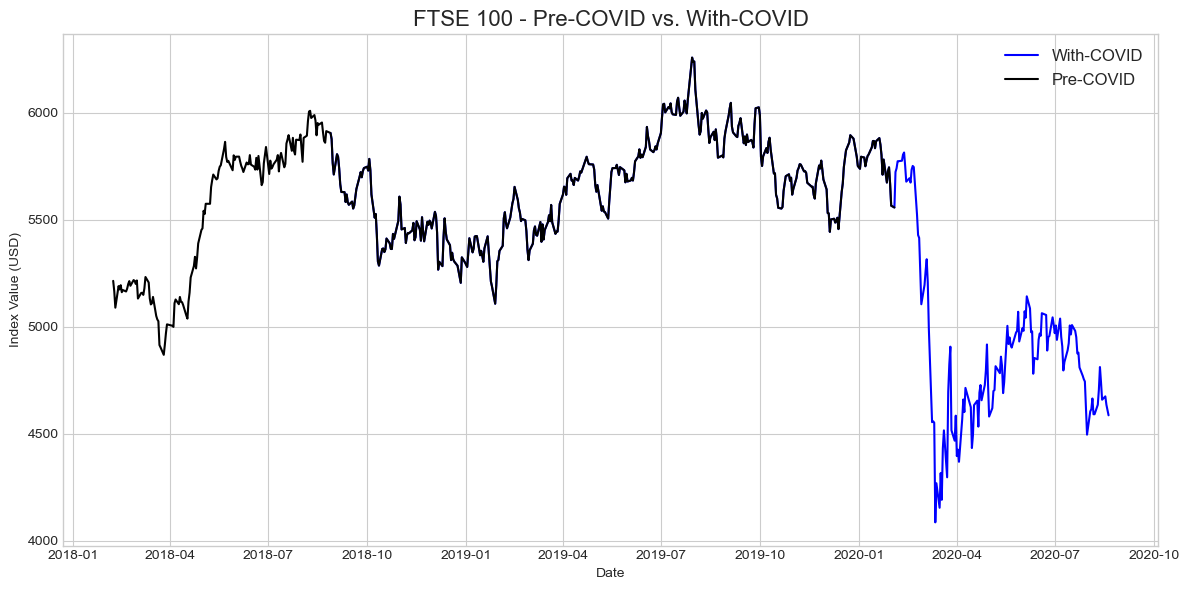

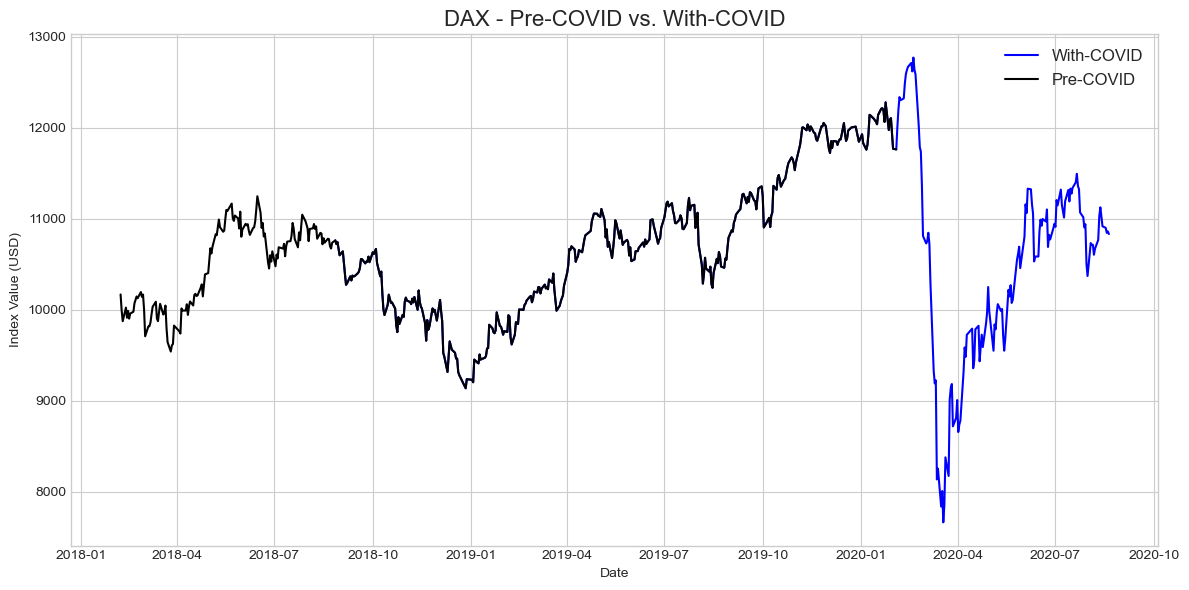

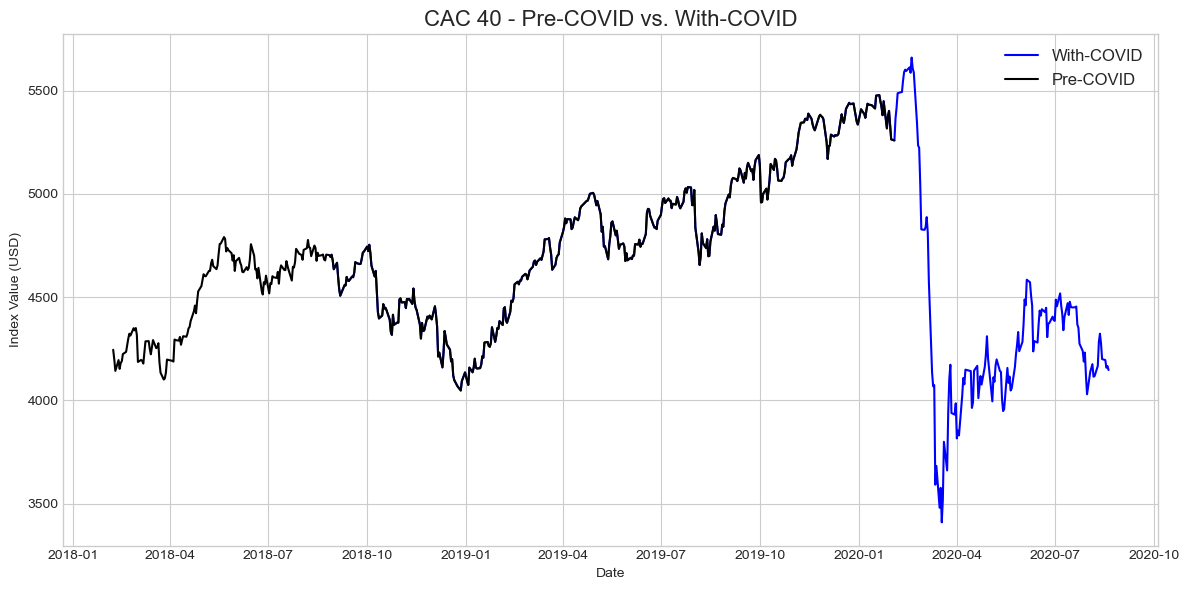

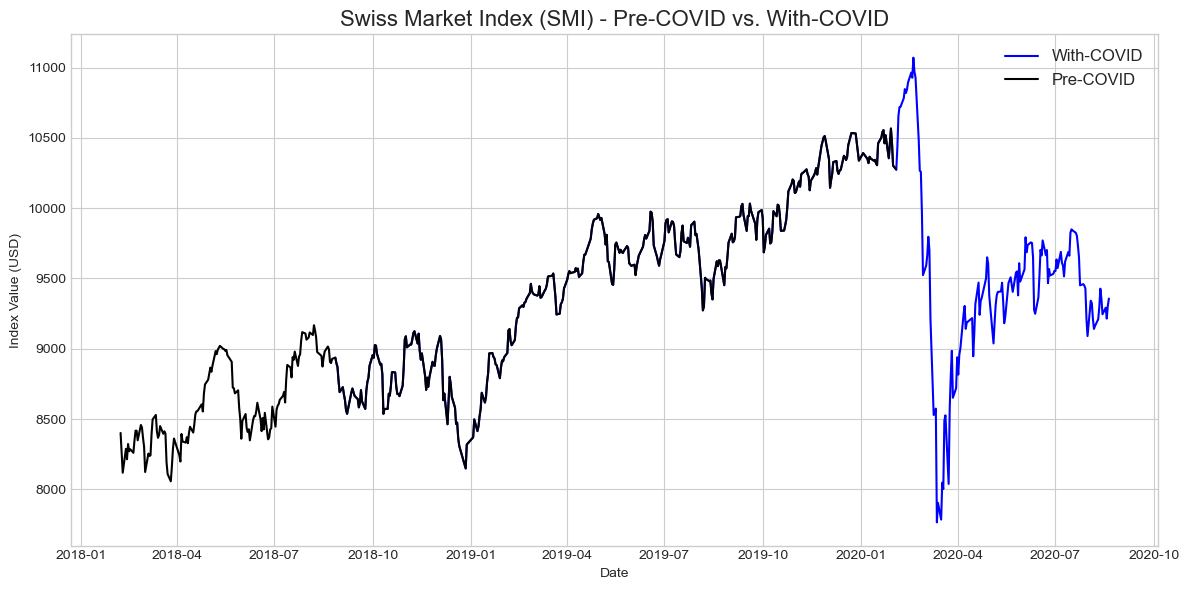

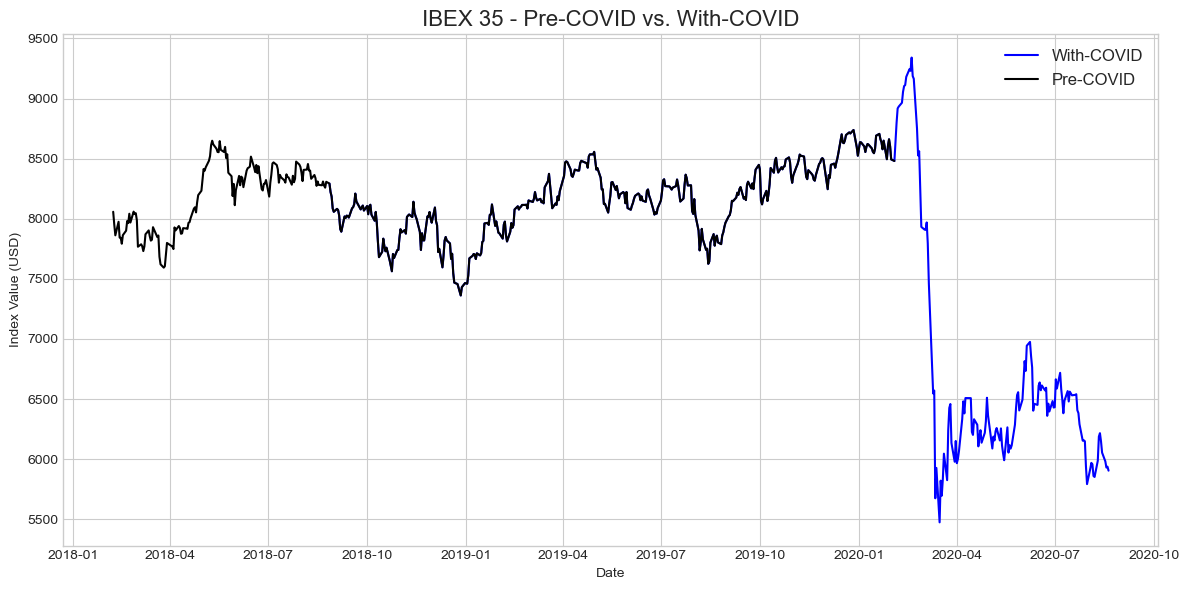

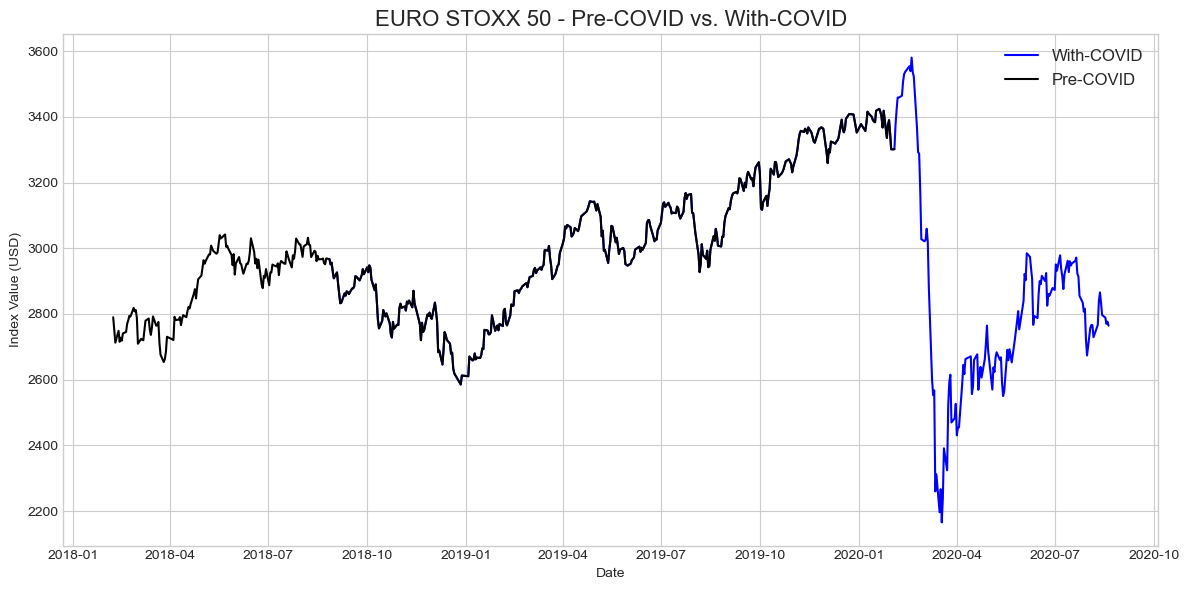

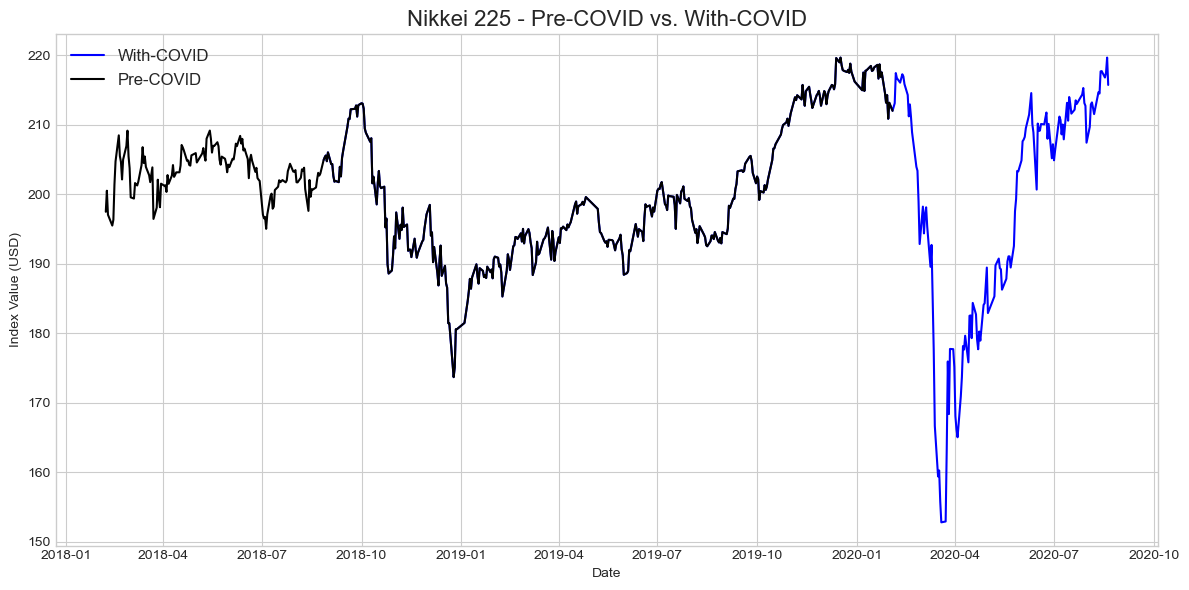

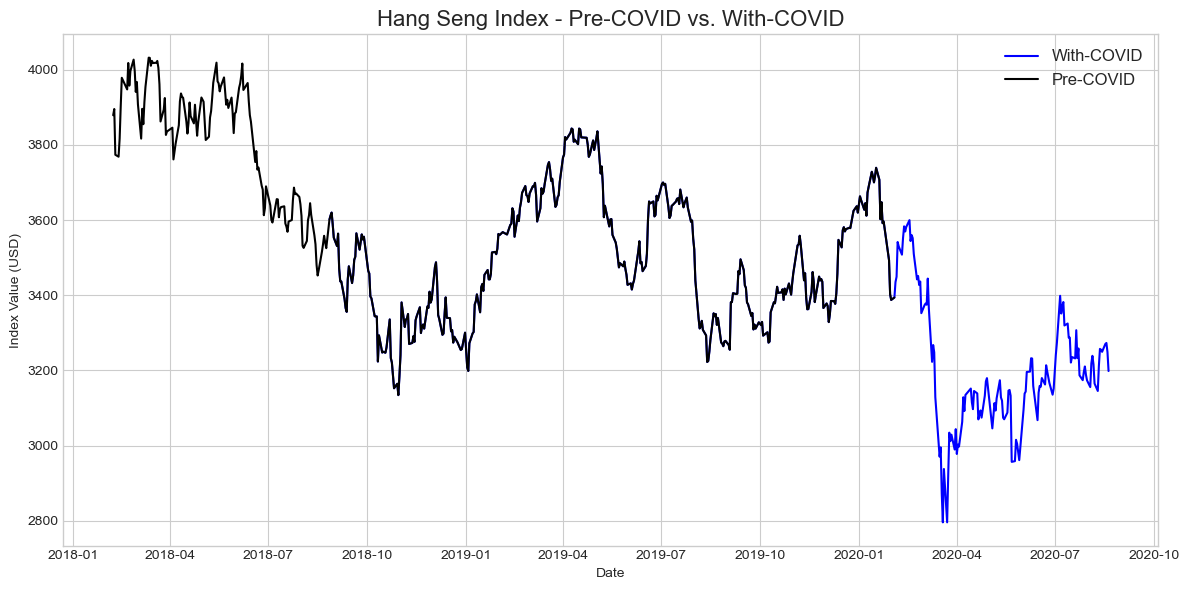

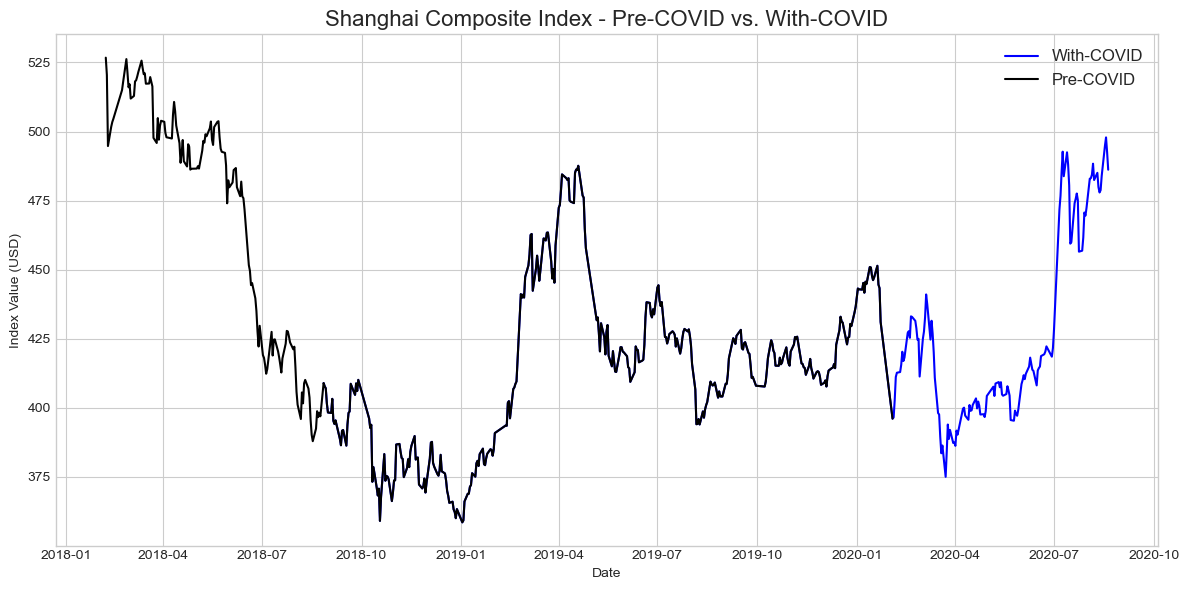

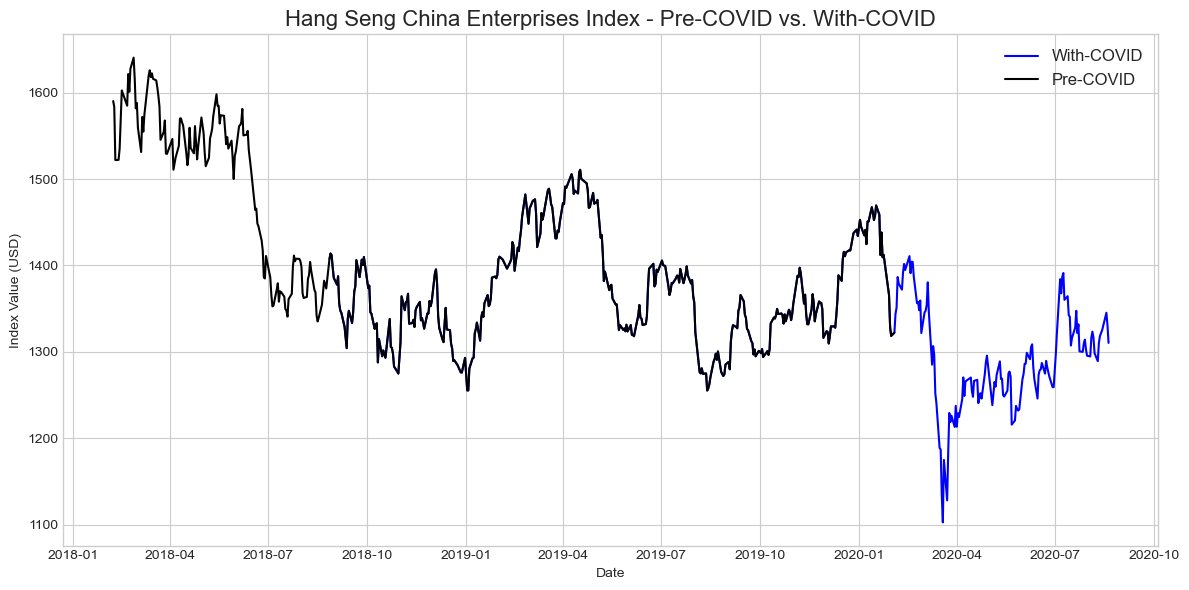

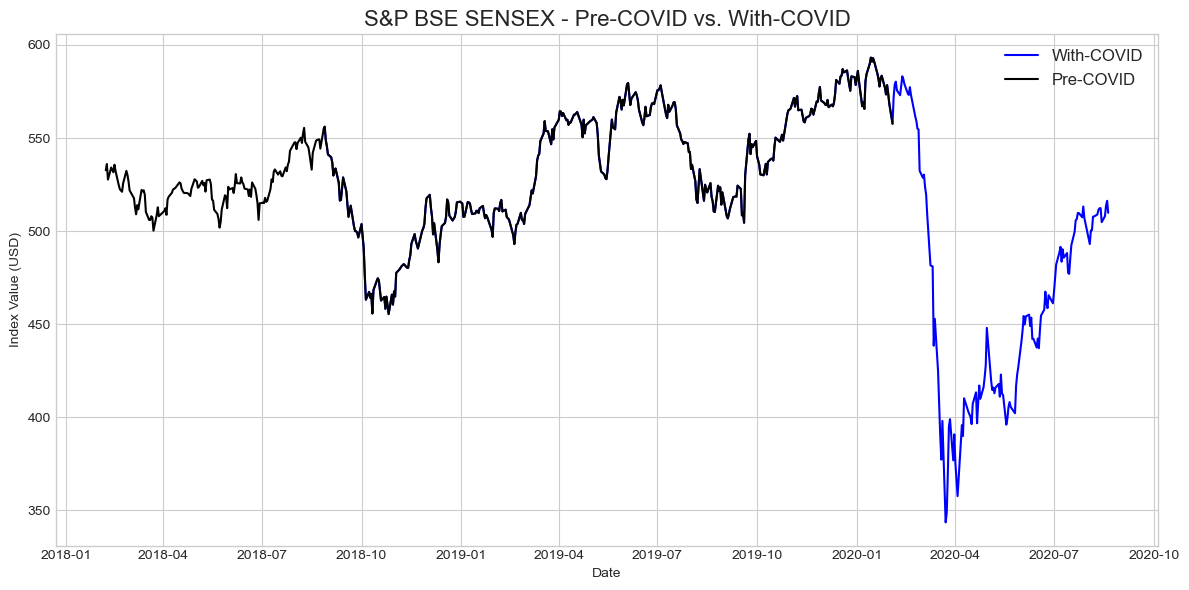

In [40]:
# Set general plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Loop over all indices
for ticker, info in Equity_ind.items():
    fig, ax = plt.subplots(figsize=(12, 6))


    # Plot with-COVID
    if info["index_usd_values_with_covid"] is not None:
        ax.plot(
            info["index_usd_values_with_covid"].index, 
            info["index_usd_values_with_covid"].iloc[:, 0], 
            label='With-COVID', 
            color='blue'
        )

    # Plot pre-COVID
    if info["index_usd_values_pre_covid"] is not None:
        ax.plot(
            info["index_usd_values_pre_covid"].index, 
            info["index_usd_values_pre_covid"].iloc[:, 0], 
            label='Pre-COVID', 
            color='black'
        )

    ax.set_title(f"{info['name']} - Pre-COVID vs. With-COVID", fontsize=16)
    ax.set_ylabel('Index Value (USD)')
    ax.set_xlabel('Date')
    ax.legend(fontsize=12)
    ax.grid(True)

    plt.tight_layout()
    plt.show()
